# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (UTI), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [3]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
import io
import sys
from contextlib import redirect_stdout
%matplotlib inline

In [4]:
import lifelines
print(lifelines.__version__)

0.26.0


In [5]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [7]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [8]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [9]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [10]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [9]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    if (i<3) or (i>11):
        data2019_month["%s" %i]['season'] = "Winter"
    elif (i>2) and (i<6):
        data2019_month["%s" %i]['season'] = "Spring"
    elif (i>5) and (i<9):
        data2019_month["%s" %i]['season'] = "Summer"
    elif (i>8) and (i<12):
        data2019_month["%s" %i]['season'] = "Autumn"
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    if (i<3) or (i>11):
        data2020_month["%s" %i]['season'] = "Winter"
    elif (i>2) and (i<6):
        data2020_month["%s" %i]['season'] = "Spring"
    elif (i>5) and (i<9):
        data2020_month["%s" %i]['season'] = "Summer"
    elif (i>8) and (i<12):
        data2020_month["%s" %i]['season'] = "Autumn"
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    if (i<3) or (i>11):
        data2021_month["%s" %i]['season'] = "Winter"
    elif (i>2) and (i<6):
        data2021_month["%s" %i]['season'] = "Spring"
    elif (i>5) and (i<9):
        data2021_month["%s" %i]['season'] = "Summer"
    elif (i>8) and (i<12):
        data2021_month["%s" %i]['season'] = "Autumn"
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [10]:
data.shape

(108000, 169)

In [306]:
data.describe(include='all')

In [11]:
# print(list(data.columns))

### 1-2- Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [13]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [14]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

#data.CCI.value_counts()

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [15]:
#dropping any variable with more than 50 percent missing values
perc = 50.0
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].dropna(axis=1, thresh=min_count)
data.shape

(108000, 170)

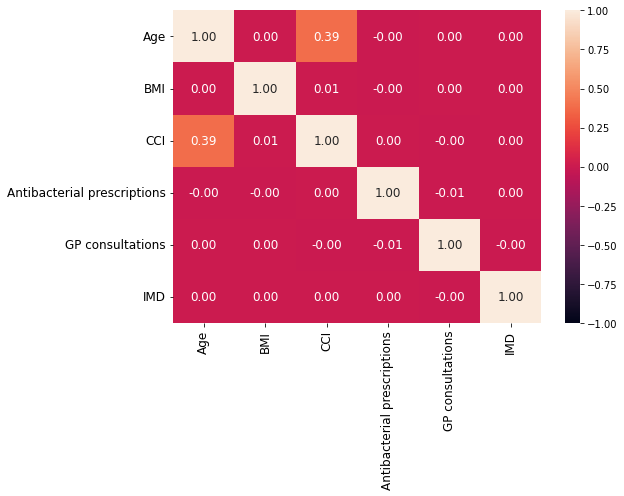

In [16]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd' ]].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_urti.jpg')
plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [17]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = 0

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [18]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data = data.replace({"sex": dict_sex})
data = data.replace({"smoking_status": dict_smoking})

In [19]:
if 'bmi' in data.columns:
    imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
    data['bmi_imp'] = np.nan
    data['bmi_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]

In [20]:
if 'imd' in data.columns:
    imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
    data['imd_imp'] = np.nan
    data['imd_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd']]))[:,4]

In [21]:
if 'smoking_status' in data.columns:
    imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
    data['smoking_status_imp'] = np.nan
    data['smoking_status_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status']]))[:,5]

In [22]:
if 'ethnicity' in data.columns:
    imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
    data['ethnicity_imp'] = np.nan
    data['ethnicity_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity']]))[:,6]

In [23]:
if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
    imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
    data['gp_count_imp'] = np.nan
    data['gp_count_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count']]))[:,7]

In [24]:
if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() > 0):
    imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
    data['antibacterial_brit_imp'] = np.nan
    data['antibacterial_brit_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count', 'antibacterial_brit']]))[:,8]

### 1-4- Translating states with dictionaries

In [26]:
# define dictionaries
dict_sex = {0: 'Female', 1: 'Male'}
# dict_BMI_cat= {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
#                 np.nan: 'Unknown'}
# dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
# dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_ethnicity_imp = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown'}
dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked'}
# dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
# dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
#                        np.nan: 'Unknown'}
# dict_gp_count_cat= {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [27]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
# data = data.replace({"BMI_cat": dict_BMI_cat})
# data = data.replace({"imd": dict_imd_imp})
data = data.replace({"ethnicity_imp": dict_ethnicity_imp})
data = data.replace({"smoking_status_imp": dict_smoking_imp})
# data = data.replace({"smoking_status": dict_smoking_status})
# data = data.replace({"gp_count_cat": dict_gp_count_cat})
data = data.replace({"flu_vaccine": dict_flu})

In [28]:
# categorising
data['BMI_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,200], labels=['Underweight', 'Healthy weight', 
                                                                                        'Overweight', 'Obese'])
data['gp_count_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

In [308]:
# save data
# data.to_csv("output/hospitalisation_prediction_uti/data_imputed.csv")

# input_file_path = makeFilePath("output/hospitalisation_prediction_uti/", "data_imputed.csv")
# data = pd.read_csv(input_file_path)

# data = pd.read_csv('output/hospitalisation_prediction_uti/data_imputed.csv')
# data.shape#head()

(108000, 181)

### 1-5- Polynimial featuring

In [ ]:
X = data[['age','bmi']]
poly = PolynomialFeatures(4)#, interaction_only=True)
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly)#, columns=['one', 'age', 'bmi', 'poly_age_bmi_1', 'poly_age_bmi_2', 'poly_age_bmi_3'])
# X = pd.concat([X, X_poly], axis=1)
X_poly

## 2- Plots
### 2-1- Continuous factors

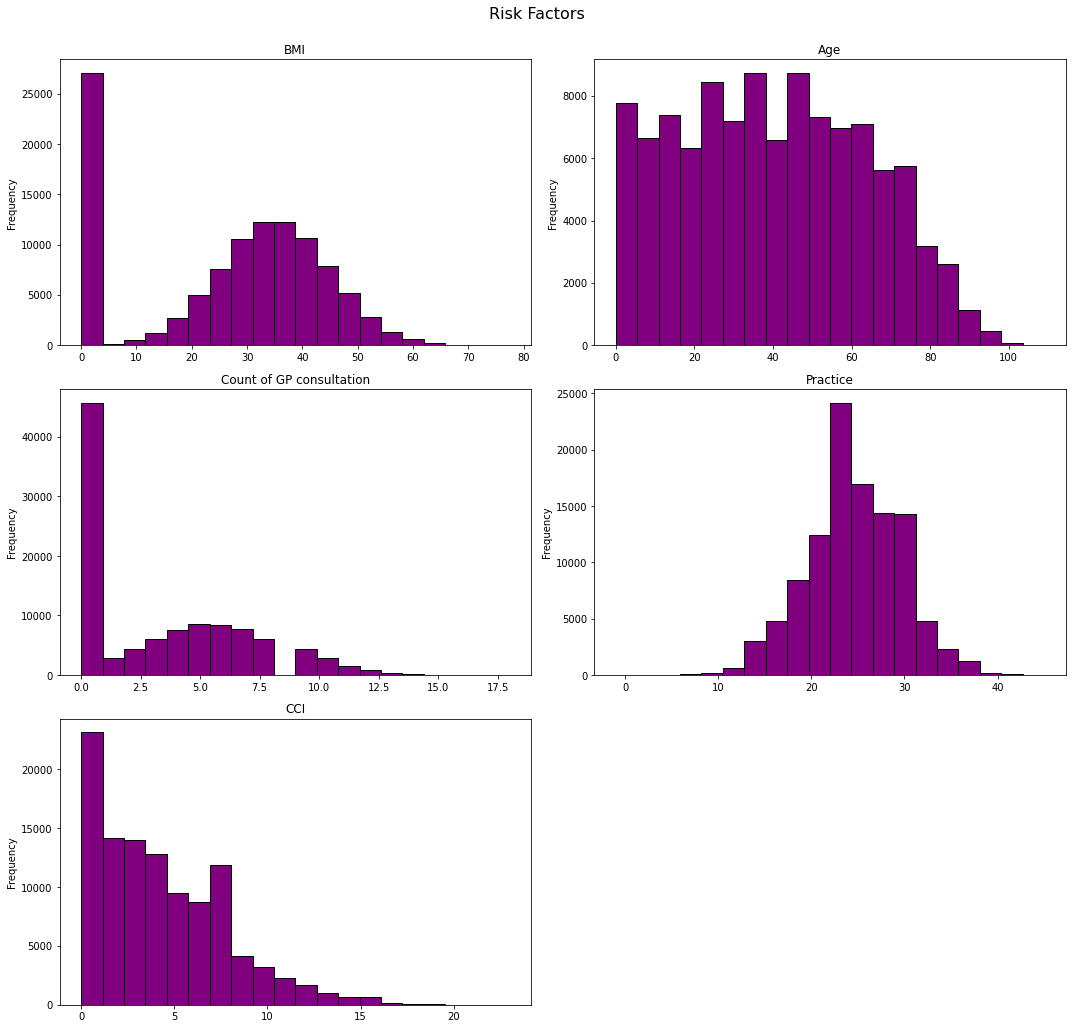

In [420]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/risk_factors_cont.jpg')
plt.show()

In [1]:
# print(list(data.columns))

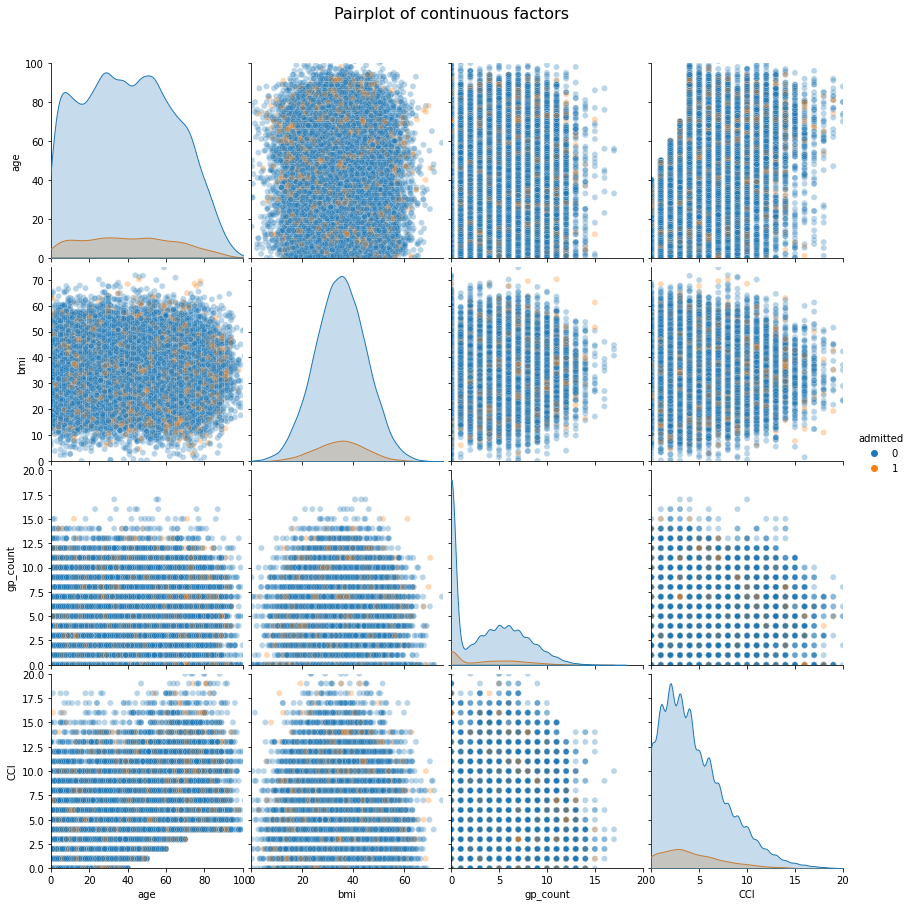

In [30]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'admitted', # 'antibacterial_brit', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
                plot_kws={'alpha':0.3},
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
#plt.savefig('../output/hospitalisation_prediction_uti/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

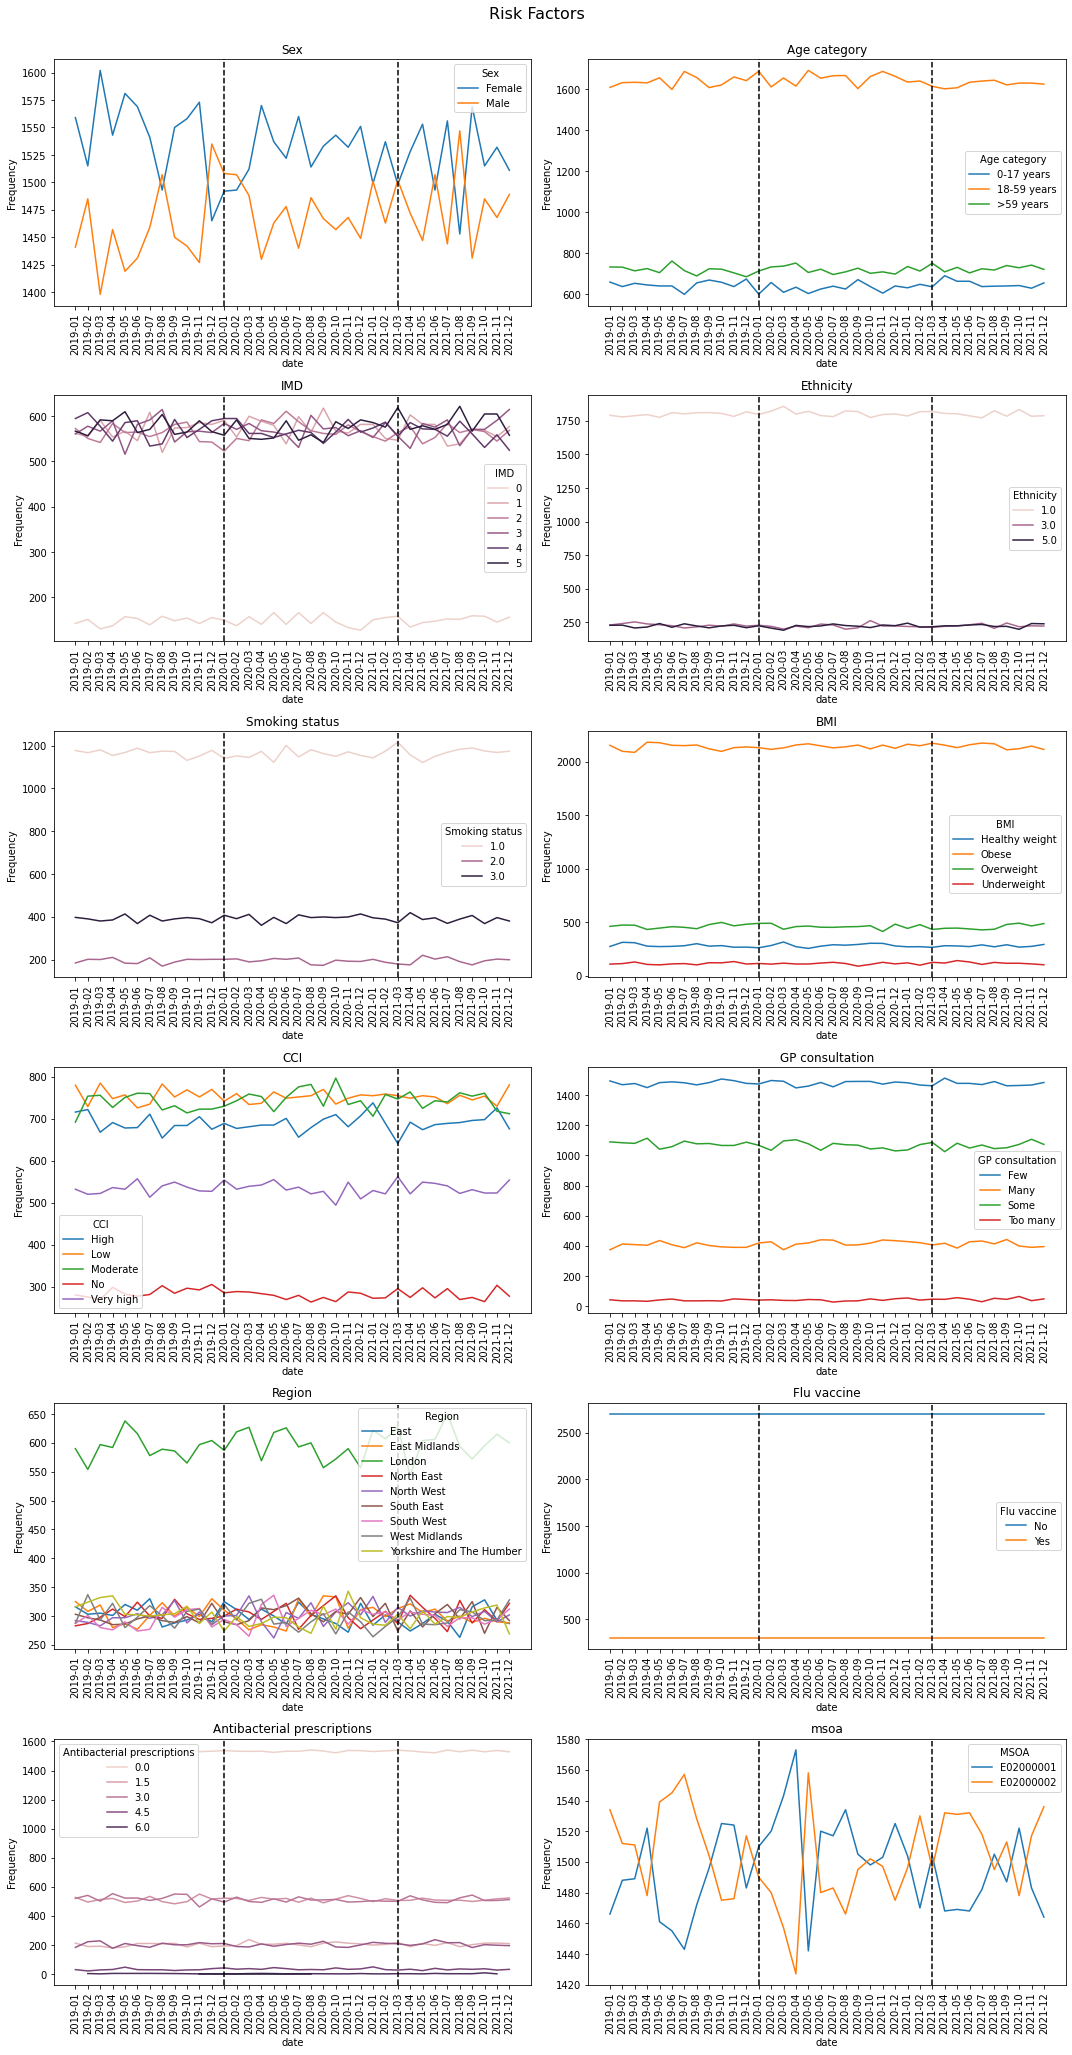

In [421]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_brit', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/risk_factors_cat.jpg')
plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- UTI

In [309]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

#### UTI-1

In [439]:
data_uti_1 = data[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                   'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',# 'antibacterial_brit',#_imp',
                   'hx_hosp', 'CCI_cat', 'CCI', 'died_date', 'deregistered_date', 'season',
                    'gp_cons_uti_1', 'gp_cons_uti_ab_1',
                    'uti_date_1', 'incdt_uti_date_1', 'admitted_uti_date_1',
                    'sgss_gp_cov_uti_date_1']]

data_uti_1 = data_uti_1[data_uti_1['uti_date_1'].notnull()]

data_uti_1.shape

(265, 27)

In [440]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_1
data_uti_1 = data_uti_1[data_uti_1['sgss_gp_cov_uti_date_1'] == 0]
data_uti_1.shape

(234, 27)

In [441]:
data_uti_1.columns

Index(['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count',
       'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI', 'died_date',
       'deregistered_date', 'season', 'gp_cons_uti_1', 'gp_cons_uti_ab_1',
       'uti_date_1', 'incdt_uti_date_1', 'admitted_uti_date_1',
       'sgss_gp_cov_uti_date_1'],
      dtype='object')

#### UTI-2

In [442]:
data_uti_2 = data[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                   'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',# 'antibacterial_brit',#_imp', 
                   'hx_hosp', 'CCI_cat', 'CCI', 'died_date', 'deregistered_date', 'season',
                    'gp_cons_uti_2', 'gp_cons_uti_ab_2',
                    'uti_date_2', 'incdt_uti_date_2', 'admitted_uti_date_2',
                    'sgss_gp_cov_uti_date_2']]

data_uti_2 = data_uti_2[data_uti_2['uti_date_2'].notnull()]

data_uti_2.shape

(321, 27)

In [443]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_2
data_uti_2 = data_uti_2[data_uti_2['sgss_gp_cov_uti_date_2'] == 0]
data_uti_2.shape

(288, 27)

In [444]:
data_uti_2.columns

Index(['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count',
       'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI', 'died_date',
       'deregistered_date', 'season', 'gp_cons_uti_2', 'gp_cons_uti_ab_2',
       'uti_date_2', 'incdt_uti_date_2', 'admitted_uti_date_2',
       'sgss_gp_cov_uti_date_2'],
      dtype='object')

#### UTI_3

In [445]:
data_uti_3 = data[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                   'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',# 'antibacterial_brit',#_imp', 
                   'hx_hosp', 'CCI_cat', 'CCI', 'died_date', 'deregistered_date', 'season',
                    'gp_cons_uti_3', 'gp_cons_uti_ab_3',
                    'uti_date_3', 'incdt_uti_date_3', 'admitted_uti_date_3',
                    'sgss_gp_cov_uti_date_3']]

data_uti_3 = data_uti_3[data_uti_3['uti_date_3'].notnull()]

data_uti_3.shape

(306, 27)

In [446]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_3
data_uti_3 = data_uti_3[data_uti_3['sgss_gp_cov_uti_date_3'] == 0]
data_uti_3.shape

(270, 27)

In [447]:
data_uti_3.columns

Index(['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count',
       'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI', 'died_date',
       'deregistered_date', 'season', 'gp_cons_uti_3', 'gp_cons_uti_ab_3',
       'uti_date_3', 'incdt_uti_date_3', 'admitted_uti_date_3',
       'sgss_gp_cov_uti_date_3'],
      dtype='object')

#### UTI_4

In [448]:
data_uti_4 = data[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                   'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                   'hx_hosp', 'CCI_cat', 'CCI', 'died_date', 'deregistered_date', 'season',
                   'gp_cons_uti_4', 'gp_cons_uti_ab_4',
                   'uti_date_4', 'incdt_uti_date_4', 'admitted_uti_date_4',
                   'sgss_gp_cov_uti_date_4']]

data_uti_4 = data_uti_4[data_uti_4['uti_date_4'].notnull()]

data_uti_4.shape

(275, 27)

In [449]:
# exclusion of covid positive 90 days before and 30 days after dx with uti_4
data_uti_4 = data_uti_4[data_uti_4['sgss_gp_cov_uti_date_4'] == 0]
data_uti_4.shape

(243, 27)

In [450]:
data_uti_4.columns

Index(['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count',
       'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI', 'died_date',
       'deregistered_date', 'season', 'gp_cons_uti_4', 'gp_cons_uti_ab_4',
       'uti_date_4', 'incdt_uti_date_4', 'admitted_uti_date_4',
       'sgss_gp_cov_uti_date_4'],
      dtype='object')

#### Combining UTI_1, UTI_2, UTI_3, and UTI_4

In [451]:
data_uti_1.rename(columns={'uti_date_1': 'uti_date', 'incdt_uti_date_1': 'incdt_uti_date', 
                           'gp_cons_uti_1': 'gp_cons_uti', 'gp_cons_uti_ab_1': 'gp_cons_uti_ab',
                           'incdt_uti_date_1': 'incdt_uti_date', #'prevl_uti_date_1': 'prevl_uti_date',
                           'admitted_uti_date_1': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_1': 'sgss_gp_cov_uti_date'},
                inplace=True)
data_uti_2.rename(columns={'uti_date_2': 'uti_date', 'incdt_uti_date_2': 'incdt_uti_date',
                           'gp_cons_uti_2': 'gp_cons_uti', 'gp_cons_uti_ab_2': 'gp_cons_uti_ab',
                           'incdt_uti_date_2': 'incdt_uti_date', #'prevl_uti_date_2': 'prevl_uti_date', 
                           'admitted_uti_date_2': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_2': 'sgss_gp_cov_uti_date'},
                inplace=True)
data_uti_3.rename(columns={'uti_date_3': 'uti_date', 'incdt_uti_date_3': 'incdt_uti_date',
                           'gp_cons_uti_3': 'gp_cons_uti', 'gp_cons_uti_ab_3': 'gp_cons_uti_ab',
                           'incdt_uti_date_3': 'incdt_uti_date', #'prevl_uti_date_3': 'prevl_uti_date', 
                           'admitted_uti_date_3': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_3': 'sgss_gp_cov_uti_date'},
                 inplace=True)
data_uti_4.rename(columns={'uti_date_4': 'uti_date', 'incdt_uti_date_4': 'incdt_uti_date', 
                           'gp_cons_uti_4': 'gp_cons_uti', 'gp_cons_uti_ab_4': 'gp_cons_uti_ab',
                           'incdt_uti_date_4': 'incdt_uti_date', #'prevl_uti_date_4': 'prevl_uti_date',
                           'admitted_uti_date_4': 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_4': 'sgss_gp_cov_uti_date'}, 
                 inplace=True)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4])
data_uti.reset_index(inplace=True, drop=True)
data_uti.shape

(1035, 27)

In [452]:
data_uti.shape

(1035, 27)

#### Adding event and duration columns

In [453]:
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')
data_uti.shape

(1035, 27)

In [454]:
#scenario 1
#not hosped (nothing happened)
#data_uti = data_uti[data_uti['admitted_uti_date'].notnull()]
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0

In [455]:
#scenario 2
# become a case (uncensoring)
#calculating days between infection dx and hosp
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 130)), 'event_uti_admitted'] = 1
data_uti['event_uti_admitted'].value_counts()

0.0    719
1.0     38
Name: event_uti_admitted, dtype: int64

In [456]:
#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]
data_uti['delta_uti_admitted'].value_counts()

856.0     3
671.0     3
949.0     3
115.0     2
1103.0    2
         ..
1069.0    1
570.0     1
126.0     1
219.0     1
117.0     1
Name: delta_uti_admitted, Length: 280, dtype: int64

In [457]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_uti.loc[data_uti['delta_admitted_died'] > 0, 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    752
1.0     37
Name: event_uti_admitted, dtype: int64

In [458]:
#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] < 130)), 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    754
1.0     37
Name: event_uti_admitted, dtype: int64

In [459]:
#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_uti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

987

In [460]:
#censor patients that had a history of hospital admission
# data_uti.loc[data_uti['hx_hosp'] == 1, 'event_uti_admitted'] = 0

In [461]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)
data_uti['event_uti_admitted'].value_counts()

0.0    991
1.0     37
Name: event_uti_admitted, dtype: int64

In [462]:
#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 130)
data_uti.loc[(data_uti['duration_uti_admitted'] > 130), 'duration_uti_admitted'] = 130
data_uti['duration_uti_admitted'].value_counts()

130.0    990
84.0       2
81.0       2
115.0      2
87.0       2
122.0      2
105.0      2
50.0       1
95.0       1
42.0       1
113.0      1
98.0       1
54.0       1
13.0       1
101.0      1
106.0      1
90.0       1
88.0       1
33.0       1
126.0      1
28.0       1
4.0        1
55.0       1
102.0      1
27.0       1
83.0       1
38.0       1
82.0       1
67.0       1
30.0       1
116.0      1
8.0        1
117.0      1
Name: duration_uti_admitted, dtype: int64

In [463]:
data_uti[data_uti['duration_uti_admitted']<0][['delta_uti_admitted', 'uti_date', 'admitted_uti_date', 'delta_uti_admitted', 'delta_admitted_died_deregistered', 'duration_uti_admitted']]

,delta_uti_admitted,uti_date,admitted_uti_date,delta_uti_admitted,delta_admitted_died_deregistered,duration_uti_admitted


In [464]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 130)), 'event_uti_admitted'] = 1

#### Separate data of UTI
We separate data of UTI to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [465]:
# no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]

# with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]

print(f'shape of data_uti_no_abs_incdt: {data_uti_no_abs_incdt.shape}')
print(f'shape of data_uti_abs_incdt: {data_uti_abs_incdt.shape}')
print(f'shape of data_uti_no_abs_prevl: {data_uti_no_abs_prevl.shape}')
print(f'shape of data_uti_abs_prevl: {data_uti_abs_prevl.shape}')

shape of data_uti_no_abs_incdt: (845, 33)
shape of data_uti_abs_incdt: (89, 33)
shape of data_uti_no_abs_prevl: (79, 33)
shape of data_uti_abs_prevl: (15, 33)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- UTI
#### 4-1-1- Incident hospital admission related to UTI with no antibiotics

In [466]:
data_uti_no_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count',
       'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI', 'died_date',
       'deregistered_date', 'season', 'gp_cons_uti', 'gp_cons_uti_ab',
       'uti_date', 'incdt_uti_date', 'admitted_uti_date',
       'sgss_gp_cov_uti_date', 'event_uti_admitted', 'delta_uti_admitted',
       'delta_admitted_died', 'delta_admitted_deregistered',
       'delta_admitted_died_deregistered', 'duration_uti_admitted'],
      dtype='object')

In [467]:
data_uti_no_abs_incdt.shape

(845, 33)

In [468]:
#keep relevant variables
# data_uti_no_abs_incdt = data_uti_no_abs_incdt[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count_imp', 'flu_vaccine',
#                                                'region', 'antibacterial_brit_imp', 'imd_imp', 'ethnicity_imp', 'CCI_cat', 'CCI',
#                                                'event_uti_admitted', 'duration_uti_admitted']]

data_uti_no_abs_incdt = data_uti_no_abs_incdt[['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
                                                 'event_uti_admitted', 'duration_uti_admitted']]

In [469]:
# printing number of missing values in each variable 
data_uti_no_abs_incdt.isnull().sum()

age                       0
bmi_imp                   0
gp_count_imp              0
flu_vaccine               0
sex                       0
region                    0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
smoking_status_imp        0
event_uti_admitted        0
duration_uti_admitted     0
dtype: int64

In [341]:
# #drop ros with missing values
# data_uti_no_abs_incdt = data_uti_no_abs_incdt.dropna(axis='rows')
# # data_uti = data_uti.drop(columns=['smoking_status'])
# data_uti_no_abs_incdt.isnull().sum()

In [470]:
data_uti_no_abs_incdt.columns

Index(['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region',
       'season', 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp',
       'smoking_status_imp', 'event_uti_admitted', 'duration_uti_admitted'],
      dtype='object')

In [471]:
fold_thre = len(data_uti_no_abs_incdt)-round(len(data_uti_no_abs_incdt)/4)
data_uti_no_abs_incdt_train = data_uti_no_abs_incdt.iloc[:fold_thre]
data_uti_no_abs_incdt_test = data_uti_no_abs_incdt.iloc[fold_thre:]

print(f'shape of data_uti_no_abs_incdt for training: {data_uti_no_abs_incdt_train.shape}')
print(f'shape of data_uti_no_abs_incdt for testing: {data_uti_no_abs_incdt_test.shape}')

shape of data_uti_no_abs_incdt for training: (634, 13)
shape of data_uti_no_abs_incdt for testing: (211, 13)


In [472]:
cph_uti_no_abs_incdt = CoxPHFitter()
cph_uti_no_abs_incdt.fit(data_uti_no_abs_incdt_train,
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + season + ethnicity_imp + season + smoking_status_imp"
        )
cph_uti_no_abs_incdt.print_summary()
# cph_uti_no_abs_incdt_summary = cph_uti_no_abs_incdt.print_summary(style="html")
# cph_uti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 634 total observations, 608 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 634
number of events observed = 26
   partial log-likelihood = -153.31
         time fit was run = 2022-03-02 09:43:11 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age                                  0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
antibacterial_brit_imp              -0.07       0.93       0.15            -0.36             0.21                 0.70                 1.24
bmi_imp                              0.01       1.01       0.02            -0.04             0.05                 0.96                 1.05
ethnicity_imp[T.Black]               2.44      11.51       1.29            -0.08             4.96                 0.93               142.92
ethnicity_imp[T.Mixed]               0.21       1.23       0.89            -1.55             1.96                 0.21                 7.08
ethnicity_imp[T.Other]               0.29       1.33       0.79            -1.26             1.84                 0.28                 6.29
ethnicity_imp[T.White]              -0.31       0.73       0.58            -1.44             0.82                 0.24                 2.26
flu_vaccine[T.Yes]                   1.07       2.91       0.53             0.03             2.11                 1.03                 8.25
gp_count_imp                         0.01       1.01       0.06            -0.11             0.13                 0.90                 1.14
imd_imp                              0.01       1.01       0.14            -0.27             0.29                 0.76                 1.33
region[T.East Midlands]              0.33       1.39       0.69            -1.02             1.69                 0.36                 5.40
region[T.London]                    -0.51       0.60       0.75            -1.97             0.95                 0.14                 2.59
region[T.North East]               -18.47       0.00    5840.08        -11464.82         11427.89                 0.00                  inf
region[T.North West]               -17.59       0.00    2802.29         -5509.98          5474.81                 0.00                  inf
region[T.South East]                 0.04       1.04       0.81            -1.55             1.63                 0.21                 5.09
region[T.South West]                 0.08       1.09       0.83            -1.53             1.70                 0.22                 5.48
region[T.West Midlands]              0.35       1.42       0.73            -1.07             1.78                 0.34                 5.91
region[T.Yorkshire and The Humber]  -0.88       0.41       1.16            -3.15             1.38                 0.04                 3.99
season[T.Spring]                    -0.57       0.57       0.63            -1.81             0.67                 0.16                 1.96
season[T.Summer]                    -0.19       0.83       0.59            -1.36             0.97                 0.26                 2.65
season[T.Winter]                     0.53       1.70       0.51            -0.47             1.53                 0.62                 4.62
sex[T.Male]                          0.33       1.40       0.41            -0.48             1.14                 0.62                 3.14
smoking_status_imp[T.Never smoked]   0.76       2.13       0.61            -0.43             1.95                 0.65                 7.01
smoking_status_imp[T.Smoker]        -0.01       0.99       0.50            -1.00             0.98                 

In [473]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [474]:
output = GetPrintSummary(cph_uti_no_abs_incdt)

with open('../output/hospitalisation_prediction_uti/cph_uti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

8408


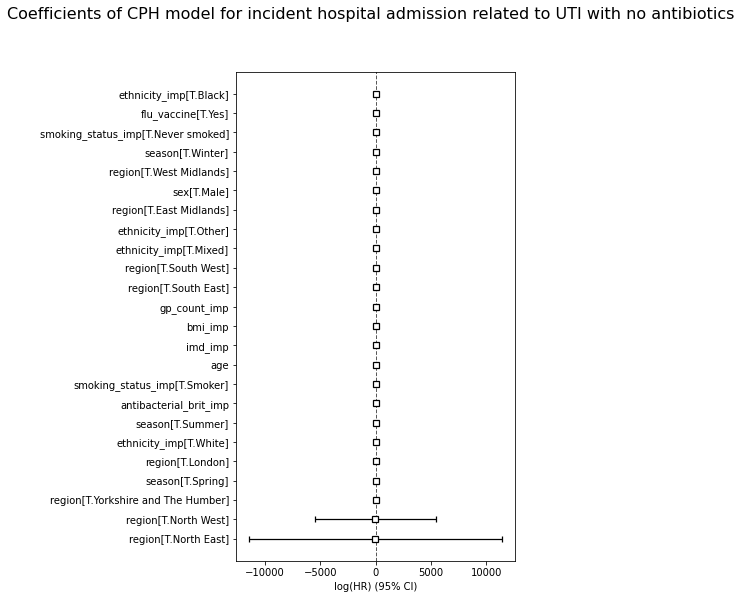

In [475]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to UTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_uti/coefficients_cph_uti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [476]:
# concordance index of cph model with testing data
concord_index_uti_no_abs_incdt_test = concordance_index(data_uti_no_abs_incdt_test['event_uti_admitted'], -cph_uti_no_abs_incdt.predict_partial_hazard(data_uti_no_abs_incdt_test), data_uti_no_abs_incdt_test['duration_uti_admitted'])
print(f'Concordance index for uti_no_abs_incdt with testing data: {concord_index_uti_no_abs_incdt_test}')
# print(concordance_index(data_uti_no_abs_incdt_test['event_uti_admitted'], -cph_uti_no_abs_incdt.predict_partial_hazard(data_uti_no_abs_incdt_test), data_uti_no_abs_incdt_test['duration_uti_admitted']))

Concordance index for uti_no_abs_incdt with testing data: 0.4203883495145631


In [477]:
a = [concord_index_uti_no_abs_incdt_test]
np.savetxt('../output/hospitalisation_prediction_uti/concord_index_uti_no_abs_incdt_test.txt', a, delimiter=',')

ICI =  0.0063190785964454405
E50 =  0.0021122248002407584


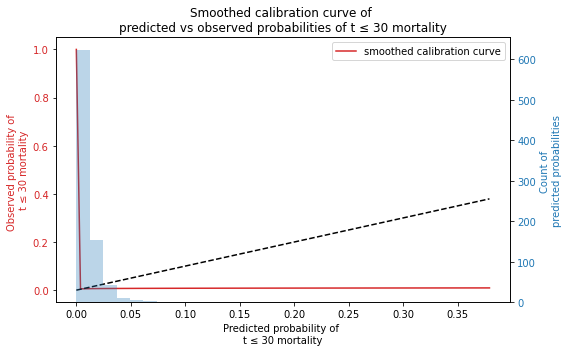

In [478]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_uti_no_abs_incdt, data_uti_no_abs_incdt, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to UTI with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_uti/calibration_cph_uti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [299]:
# print(cph_uti_no_abs_incdt.score(data_uti_no_abs_incdt_1_test))
# print(cph_uti_no_abs_incdt.concordance_index_)
# print(cph_uti_no_abs_incdt.AIC_partial_)
# print(cph_uti_no_abs_incdt.concordance_index_)

#### 4-1-2- Incident hospital admission related to UTI with antibiotics

In [279]:
data_uti_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count',
       'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI', 'died_date',
       'deregistered_date', 'season', 'gp_cons_uti', 'gp_cons_uti_ab',
       'uti_date', 'incdt_uti_date', 'admitted_uti_date',
       'sgss_gp_cov_uti_date', 'event_uti_admitted', 'delta_uti_admitted',
       'delta_admitted_died', 'delta_admitted_deregistered',
       'delta_admitted_died_deregistered', 'duration_uti_admitted'],
      dtype='object')

In [280]:
data_uti_abs_incdt.shape

(89, 33)

In [481]:
#keep relevant variables
data_uti_abs_incdt = data_uti_abs_incdt[['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', 'season', 
                                         'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
                                         'event_uti_admitted', 'duration_uti_admitted']]

In [482]:
# printing number of missing values in each variable 
data_uti_abs_incdt.isnull().sum()

age                       0
bmi_imp                   0
gp_count_imp              0
flu_vaccine               0
sex                       0
region                    0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
smoking_status_imp        0
event_uti_admitted        0
duration_uti_admitted     0
dtype: int64

In [483]:
# #drop ros with missing values
# data_uti_abs_incdt = data_uti_abs_incdt.dropna(axis='rows')
# #data_uti_abs_incdt = data_uti_abs_incdt.drop(columns=['smoking_status'])
# data_uti_abs_incdt.isnull().sum()

In [484]:
fold_thre = len(data_uti_abs_incdt)-round(len(data_uti_abs_incdt)/4)
data_uti_abs_incdt_train = data_uti_abs_incdt.iloc[:fold_thre]
data_uti_abs_incdt_test = data_uti_abs_incdt.iloc[fold_thre:]

print(f'shape of data_uti_abs_incdt for training: {data_uti_abs_incdt_train.shape}')
print(f'shape of data_uti_abs_incdt for testing: {data_uti_abs_incdt_test.shape}')

shape of data_uti_abs_incdt for training: (67, 13)
shape of data_uti_abs_incdt for testing: (22, 13)


In [485]:
cph_uti_abs_incdt = CoxPHFitter().fit(data_uti_abs_incdt_train,
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + season + smoking_status_imp"
        )
cph_uti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 67 total observations, 65 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 67
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-03-02 09:45:00 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age                                  0.06       1.06      14.08           -27.53            27.65                 0.00             1.02e+12
antibacterial_brit_imp              -1.25       0.29     331.46          -650.90           648.41                 0.00            3.98e+281
bmi_imp                             -0.12       0.88      47.88           -93.97            93.72                 0.00             5.03e+40
ethnicity_imp[T.Other]               1.29       3.65    2572.35         -5040.42          5043.01                 0.00                  inf
ethnicity_imp[T.White]               8.95    7699.31    1718.79         -3359.82          3377.72                 0.00                  inf
flu_vaccine[T.Yes]                   0.74       2.10    1988.76         -3897.15          3898.63                 0.00                  inf
gp_count_imp                        -0.74       0.48     122.96          -241.73           240.25                 0.00            2.19e+104
imd_imp                              1.86       6.43     258.18          -504.16           507.88                 0.00            3.71e+220
region[T.East Midlands]              7.82    2495.42    1595.53         -3119.36          3135.01                 0.00                  inf
region[T.London]                     0.16       1.17    1736.82         -3403.95          3404.27                 0.00                  inf
region[T.North East]                 7.27    1435.41    2224.81         -4353.28          4367.82                 0.00                  inf
region[T.North West]                 9.68   16022.26    1935.15         -3783.14          3802.51                 0.00                  inf
region[T.South East]                 2.24       9.41    1215.40         -2379.90          2384.39                 0.00                  inf
region[T.South West]                17.30   3.27e+07    1574.68         -3069.01          3103.62                 0.00                  inf
region[T.West Midlands]              4.91     136.07    1787.58         -3498.67          3508.50                 0.00                  inf
region[T.Yorkshire and The Humber]  15.48   5.28e+06    1516.14         -2956.10          2987.06                 0.00                  inf
season[T.Spring]                     4.77     117.60    1569.63         -3071.64          3081.18                 0.00                  inf
season[T.Summer]                    12.06   1.72e+05     904.04         -1759.83          1783.94                 0.00                  inf
season[T.Winter]                    15.95   8.47e+06     850.53         -1651.05          1682.95                 0.00                  inf
sex[T.Male]                          3.89      49.15     586.26         -1145.15          1152.94                 0.00                  inf
smoking_status_imp[T.Never smoked]   2.10       8.14    1182.37         -2315.30          2319.50                 0.00                  inf
smoking_status_imp[T.Smoker]         0.64       1.89     888.88         -1741.53          1742.81                 0.00                  inf

                                       z    p   -log2(p)
covariate                                               
age                                 0.00 1.00       0.00
antibacterial_brit_imp             -0.00 1.00       0.00
bmi_imp                        

In [486]:
output = GetPrintSummary(cph_uti_abs_incdt)

with open('../output/hospitalisation_prediction_uti/cph_uti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

8070


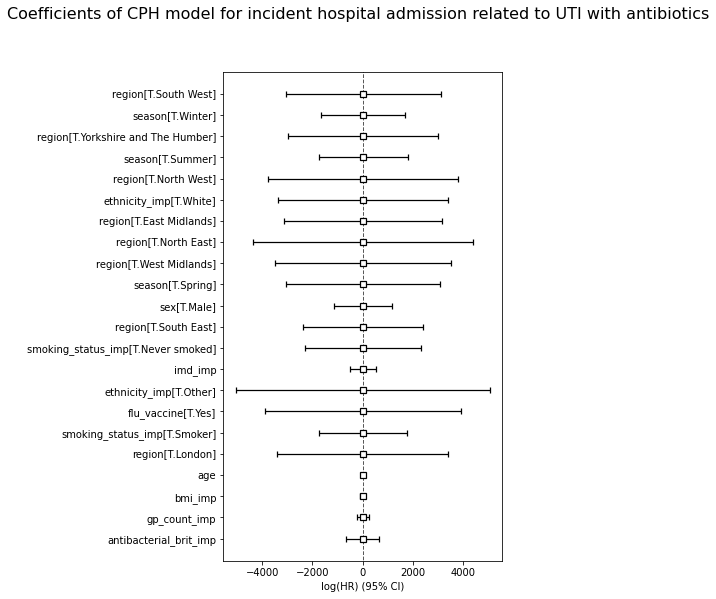

In [487]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission related to UTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_uti/coefficients_cph_uti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# concordance index of cph model with testing data
concord_index_uti_abs_incdt_test = concordance_index(data_uti_abs_incdt_test['event_uti_admitted'], -cph_uti_abs_incdt.predict_partial_hazard(data_uti_abs_incdt_test), data_uti_abs_incdt_test['duration_uti_admitted'])
print(f'Concordance index for uti_abs_incdt with testing data: {concord_index_uti_abs_incdt_test}')

In [431]:
a = [concord_index_uti_abs_incdt_test]
np.savetxt('../output/hospitalisation_prediction_uti/concord_index_uti_abs_incdt_test.txt', a, delimiter=',')

In [432]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_uti_abs_incdt, data_uti_abs_incdt, t0=30)
plt.suptitle('Calibration of CPH model for incident hospital admission related to UTI with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_uti/calibration_cph_uti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

#### 4-1-3- Prevalent hospital admission related to UTI with no antibiotics

In [289]:
data_uti_no_abs_prevl.columns

Index(['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count',
       'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 'region',
       'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp',
       'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI', 'died_date',
       'deregistered_date', 'season', 'gp_cons_uti', 'gp_cons_uti_ab',
       'uti_date', 'incdt_uti_date', 'admitted_uti_date',
       'sgss_gp_cov_uti_date', 'event_uti_admitted', 'delta_uti_admitted',
       'delta_admitted_died', 'delta_admitted_deregistered',
       'delta_admitted_died_deregistered', 'duration_uti_admitted'],
      dtype='object')

In [290]:
data_uti_no_abs_prevl.shape

(79, 33)

In [489]:
#keep relevant variables
data_uti_no_abs_prevl = data_uti_no_abs_prevl[['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', 'season', 
                                                'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
                                                'event_uti_admitted', 'duration_uti_admitted']]

In [490]:
# printing number of missing values in each variable 
data_uti_no_abs_prevl.isnull().sum()

age                       0
bmi_imp                   0
gp_count_imp              0
flu_vaccine               0
sex                       0
region                    0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
smoking_status_imp        0
event_uti_admitted        0
duration_uti_admitted     0
dtype: int64

In [491]:
# #drop ros with missing values
# data_uti_no_abs_prevl = data_uti_no_abs_prevl.dropna(axis='rows')
# #data_uti_no_abs_prevl = data_uti_no_abs_prevl.drop(columns=['smoking_status'])
# data_uti_no_abs_prevl.isnull().sum()

In [492]:
data_uti_no_abs_prevl.shape

(79, 13)

In [493]:
fold_thre = len(data_uti_no_abs_prevl)-round(len(data_uti_no_abs_prevl)/4)
data_uti_no_abs_prevl_train = data_uti_no_abs_prevl.iloc[:fold_thre]
data_uti_no_abs_prevl_test = data_uti_no_abs_prevl.iloc[fold_thre:]

print(f'shape of data_uti_no_abs_prevl for training: {data_uti_no_abs_prevl_train.shape}')
print(f'shape of data_uti_no_abs_prevl for testing: {data_uti_no_abs_prevl_test.shape}')

shape of data_uti_no_abs_prevl for training: (59, 13)
shape of data_uti_no_abs_prevl for testing: (20, 13)


In [494]:
cph_uti_no_abs_prevl = CoxPHFitter().fit(data_uti_no_abs_prevl_train,
        duration_col='duration_uti_admitted',
        event_col='event_uti_admitted',
        formula="age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + season + smoking_status_imp"
        )
cph_uti_no_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 59 total observations, 57 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-03-02 09:46:35 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age                                  0.33       1.39   13902.86        -27248.78         27249.43                 0.00                  inf
antibacterial_brit_imp               3.25      25.78  259851.46       -509296.24        509302.74                 0.00                  inf
bmi_imp                              0.55       1.73   54284.12       -106394.38        106395.47                 0.00                  inf
ethnicity_imp[T.Mixed]              -7.01       0.00 2297625.22      -4503269.69       4503255.68                 0.00                  inf
ethnicity_imp[T.Other]               4.95     141.68 2712261.04      -5315929.00       5315938.90                 0.00                  inf
ethnicity_imp[T.White]              -0.37       0.69 2575146.33      -5047194.44       5047193.70                 0.00                  inf
flu_vaccine[T.Yes]                  -8.31       0.00 1613797.35      -3162993.00       3162976.38                 0.00                  inf
gp_count_imp                        -0.72       0.49  278533.72       -545916.77        545915.33                 0.00                  inf
imd_imp                              2.25       9.50  344310.47       -674833.86        674838.36                 0.00                  inf
region[T.East Midlands]             -5.87       0.00 3650918.71      -7155675.05       7155663.32                 0.00                  inf
region[T.London]                     6.73     833.35 3208181.00      -6287912.49       6287925.94                 0.00                  inf
region[T.North East]                 9.05    8494.89 2925912.71      -5734674.49       5734692.58                 0.00                  inf
region[T.North West]                 0.68       1.97 3001515.47      -5882861.55       5882862.90                 0.00                  inf
region[T.South East]                -7.50       0.00 3515322.79      -6889913.57       6889898.57                 0.00                  inf
region[T.South West]                 7.00    1098.39 2738316.14      -5366994.01       5367008.01                 0.00                  inf
region[T.West Midlands]             -3.36       0.03 2901449.90      -5686740.66       5686733.95                 0.00                  inf
region[T.Yorkshire and The Humber]  14.12   1.35e+06 4007749.52      -7855030.61       7855058.84                 0.00                  inf
season[T.Spring]                    -7.30       0.00 2934978.97      -5752460.38       5752445.78                 0.00                  inf
season[T.Summer]                     1.68       5.39 1789826.48      -3507993.76       3507997.13                 0.00                  inf
season[T.Winter]                     4.27      71.70 1243941.42      -2438076.12       2438084.66                 0.00                  inf
sex[T.Male]                         -2.81       0.06 1305675.58      -2559079.93       2559074.30                 0.00                  inf
smoking_status_imp[T.Never smoked] -12.98       0.00 1406453.72      -2756611.60       2756585.65                 0.00                  inf
smoking_status_imp[T.Smoker]        -4.94       0.01 1126949.82      -2208785.99       2208776.11                 0.00                  inf

                                       z    p   -log2(p)
covariate                                               
age  

In [495]:
output = GetPrintSummary(cph_uti_no_abs_prevl)

with open('../output/hospitalisation_prediction_uti/cph_uti_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

8517


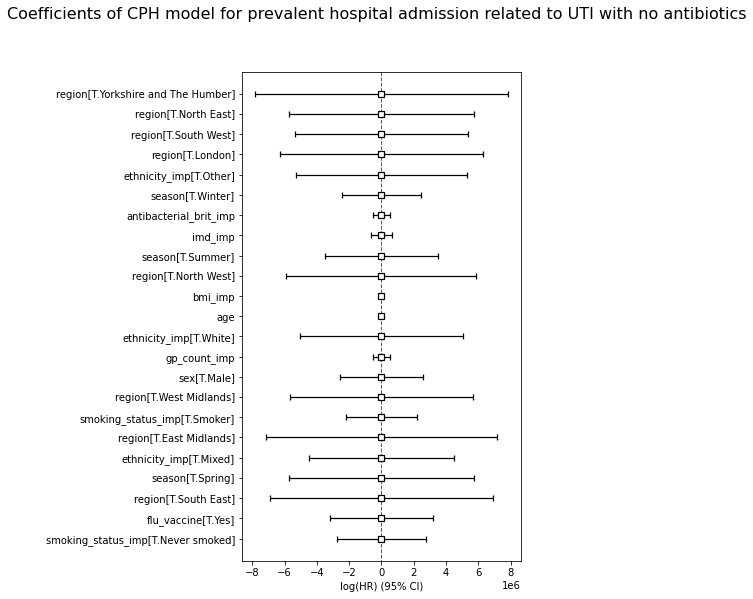

In [496]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_uti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to UTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_uti/coefficients_cph_uti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [303]:
data_uti_no_abs_prevl_test.columns

Index(['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region',
       'season', 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp',
       'event_uti_admitted', 'duration_uti_admitted'],
      dtype='object')

In [433]:
# concordance index of cph model with testing data
concord_index_uti_no_abs_prevl_test = concordance_index(data_uti_no_abs_prevl_test['event_uti_admitted'], -cph_uti_no_abs_prevl.predict_partial_hazard(data_uti_no_abs_prevl_test), data_uti_no_abs_prevl_test['duration_uti_admitted'])
print(f'Concordance index for cph_uti_no_abs_prevl with testing data: {concord_index_uti_no_abs_prevl_test}')

In [434]:
a = [concord_index_uti_no_abs_prevl_test]
np.savetxt('../output/hospitalisation_prediction_uti/concord_index_uti_no_abs_prevl_test.txt', a, delimiter=',')

In [435]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_uti_no_abs_prevl, data_uti_no_abs_prevl, t0=30)
plt.suptitle('Calibration of CPH model for prevalent hospital admission related to UTI with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_uti/calibration_cph_uti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

#### 4-1-4- Prevalent hospital admission related to UTI with antibiotics

In [385]:
# data_uti_abs_prevl.columns

In [386]:
# #keep relevant variables
# data_uti_abs_prevl = data_uti_abs_prevl[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
#                                         'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
#                                         'event_uti_admitted', 'duration_uti_admitted']]

In [387]:
# # print number of missing values in each variable 
# data_uti_abs_prevl.isnull().sum()

In [388]:
# #drop ros with missing values
# data_uti_abs_prevl = data_uti_abs_prevl.dropna(axis='rows')
# #data_uti_abs_prevl = data_uti_abs_prevl.drop(columns=['smoking_status'])
# data_uti_abs_prevl.isnull().sum()

In [389]:
# cph_uti_abs_prevl = CoxPHFitter(penalizer=0.1)
# cph_uti_abs_prevl.fit(data_uti_abs_prevl, 
#         duration_col='duration_uti_admitted',
#         event_col='event_uti_admitted',
#         formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
#         )
# cph_uti_abs_prevl.print_summary()

In [390]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_uti_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to UTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# #plt.savefig('output/repeat_ABs_outputs/coefficients_cph_uti_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [129]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction_uti/cph_uti_abs_prevl.pickle', 'wb') as f:
#     pickle.dump(cph_uti_abs_prevl, f)

# with open('output/hospitalisation_prediction_uti/cph_uti_abs_prevl.pickle', 'rb') as f:
#     cph_uti_abs_prevl = pickle.load(f)

# cph_uti_abs_prevl.summary

In [147]:
# hosp history, ab type history, 